# Part 7: Token-based — BPE tokenizer + category–sequence attention

This notebook uses:
- **`tokenizer`** — BPE tokenizer with special tokens `<PAD>` (id 0) and `<EOS>` (id 1)
- **`data_loading`** — dataset download, normalization, category vocabulary, and **token-level** dataset building
- **`model`** — `CategoryConditionedNameModel` for category-conditioned **next-token** prediction

**Model:** Words are tokenized with BPE; (X, Y, C) are token-level. The trunk has:
- **Category → sequence** cross-attention (category queries the sequence)
- **Sequence → category** cross-attention (sequence queries the category) for stronger interplay
- Causal self-attention blocks  
All trunk and MLP layers use **pre-norm** (LayerNorm before linear/attention); the **final logits layer** is not normalized.

In [1]:
import sys
from pathlib import Path

# Ensure project root is on path (run from repo root or from part6)
root = Path.cwd() if Path.cwd().name != "part7" else Path.cwd().parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from data_loading import (
    load_words_and_categories,
    build_category_vocabulary,
    get_train_val_test_splits_tokens,
    validate_dataset,
)
from tokenizer import BPETokenizer, tokenizer_vocab
from model import CategoryConditionedNameModel, ModelConfig

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

Using device: cuda
GPU: NVIDIA GeForce RTX 5060


In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")
print(f"Dataset path: {dataset_path}")

d:\dev\namegens\namegens\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [ ]:
# Load words and categories (optional: add extra CSV)

words, categories = load_words_and_categories(
    dirs_configs = [{"dir_path": dataset_path}],
    files_configs = [
        {"file_path": Path("../data/forgotten_realms_inhabitants_by_race.csv"), "name_column": "name", "category_column": "source_category"}, 
        {"file_path": Path("../data/names_multiplied.csv"), "name_column": "full_name", "category_column": "category"},
        ]
)
print(f"Loaded {len(words)} words with {len(categories)} categories")

Loaded 41221 words with 41221 categories


In [4]:
# BPE tokenizer with special tokens <PAD> (id 0) and <EOS> (id 1)
tokenizer = BPETokenizer(vocab_size=256).fit(words)
token_vocab = tokenizer_vocab(tokenizer)
cat_vocab = build_category_vocabulary(categories)

print(f"Token vocab size: {tokenizer.size}")
print(f"Category vocab size: {cat_vocab.size}")
print(f"Pad token id: {tokenizer.pad_token_id} (<PAD>)")
print(f"End token id: {tokenizer.end_token_id} (<EOS>)")
print(f"Sample tokens (first 20): {dict(list(tokenizer.itos.items())[:20])}")

Token vocab size: 256
Category vocab size: 596
Pad token id: 0 (<PAD>)
End token id: 1 (<EOS>)
Sample tokens (first 20): {0: '<PAD>', 1: '<EOS>', 2: ' ', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q'}


In [5]:
tokenizer.itos.items()

dict_items([(0, '<PAD>'), (1, '<EOS>'), (2, ' '), (3, 'a'), (4, 'b'), (5, 'c'), (6, 'd'), (7, 'e'), (8, 'f'), (9, 'g'), (10, 'h'), (11, 'i'), (12, 'j'), (13, 'k'), (14, 'l'), (15, 'm'), (16, 'n'), (17, 'o'), (18, 'p'), (19, 'q'), (20, 'r'), (21, 's'), (22, 't'), (23, 'u'), (24, 'v'), (25, 'w'), (26, 'x'), (27, 'y'), (28, 'z'), (29, 'ar'), (30, 'an'), (31, 'er'), (32, 'in'), (33, 'al'), (34, 'el'), (35, 'th'), (36, 'en'), (37, 'on'), (38, 'or'), (39, 'ra'), (40, 'il'), (41, 'st'), (42, 'sh'), (43, 'ri'), (44, 'la'), (45, 'un'), (46, 'am'), (47, 'ch'), (48, 're'), (49, 'le'), (50, 'ro'), (51, 'ul'), (52, 'ma'), (53, 'is'), (54, 'a '), (55, 'ol'), (56, 'ur'), (57, 'ta'), (58, 'da'), (59, 'ia'), (60, 'as'), (61, 'ir'), (62, 'de'), (63, 'gh'), (64, 'na'), (65, 'us'), (66, 'mar'), (67, 'et'), (68, 'and'), (69, 'e '), (70, 'es'), (71, 'os'), (72, 'ad'), (73, 'im'), (74, 'at'), (75, 'it'), (76, 'yn'), (77, 'ic'), (78, 'io'), (79, 'ka'), (80, 'ha'), (81, 'lo'), (82, 'ina'), (83, ' b'), (84, 'ie

In [6]:
# Train/val/test splits (token-level)
block_size = 24

(Xtr, Ytr, Ctr), (Xdev, Ydev, Cdev), (Xte, Yte, Cte) = get_train_val_test_splits_tokens(
    words,
    cat_vocab.normalized_categories,
    tokenizer,
    cat_vocab,
    block_size,
    train_frac=0.95,
    val_frac=0.03,
    seed=42,
)

print(f"Train: {Xtr.shape[0]}, Val: {Xdev.shape[0]}, Test: {Xte.shape[0]}")

Building train/val/test datasets (token-level)...
  Shapes: X 233740 x 24, Y 233740, C 233740
  Tensors: X torch.Size([233740, 24]), Y torch.Size([233740]), C torch.Size([233740])
  Shapes: X 7502 x 24, Y 7502, C 7502
  Tensors: X torch.Size([7502, 24]), Y torch.Size([7502]), C torch.Size([7502])
  Shapes: X 4848 x 24, Y 4848, C 4848
  Tensors: X torch.Size([4848, 24]), Y torch.Size([4848]), C torch.Size([4848])
  Train: 233740, Val: 7502, Test: 4848
Train: 233740, Val: 7502, Test: 4848


In [7]:
# Validate datasets (use token_vocab for vocab size)
validate_dataset(Xtr, Ytr, Ctr, token_vocab, cat_vocab)

# Sanity checks before training
assert Ytr.max() < tokenizer.size and Ytr.min() >= 0
assert not torch.isnan(Ytr).any()


DATASET VALIDATION
Vocab size: 256
Shapes: X torch.Size([233740, 24]), Y torch.Size([233740]), C torch.Size([233740])
  No NaNs in X, Y, C.
  X indices in [0, 255], Y in [0, 255].
  C indices in [0, 595].
✓ All validation checks passed.



In [8]:
# Model and optimizer
g = torch.Generator().manual_seed(2147483647)

config = ModelConfig(
    vocab_size=tokenizer.size,
    cat_vocab_size=cat_vocab.size,
    block_size=block_size,
    n_embd=256,
    n_hidden=512,
    num_heads=8,
    num_attention_blocks=4,
    num_mlp_layers=4,
    cat_emb_dim=256,
    dropout=0.3,
    last_layer_scale=0.1,
    category_dropout=0.2,
    unknown_category_idx=cat_vocab.stoi.get("unknown", 0),
)
model = CategoryConditionedNameModel(config).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,}")

learning_rate = 1e-3
weight_decay = 0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
n_iter = 400_000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_iter, eta_min=1e-4)

Parameters: 13,491,200


In [9]:
# Training helpers: get_batch, estimate_loss, format_time
batch_size = 256
eval_iters = 100
eval_interval = 10000
track_interval = 100

def get_batch(split: str, batch_size: int):
    data = {"train": (Xtr, Ytr, Ctr), "val": (Xdev, Ydev, Cdev), "test": (Xte, Yte, Cte)}
    X, Y, C = data[split]
    ix = torch.randint(0, X.shape[0], (batch_size,), device=X.device)
    return X[ix].to(device), Y[ix].to(device), C[ix].to(device)

@torch.no_grad()
def estimate_loss(model, eval_iters: int, batch_size: int):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            Xb, Yb, Cb = get_batch(split, batch_size)
            _, loss = model(Xb, Cb, targets=Yb)
            losses[k] = loss
        out[split] = losses.mean().item()
    model.train()
    return out

def format_time(seconds: float) -> str:
    s = int(seconds)
    h, s = divmod(s, 3600)
    m, s = divmod(s, 60)
    if h > 0:
        return f"{h}h {m}m {s}s"
    if m > 0:
        return f"{m}m {s}s"
    return f"{s}s"

In [10]:
# Training loop: progress bar, validation, LR decay, gradient clipping, early stopping
lossi = []
val_lossi = []
n_track = n_iter // track_interval
lossi_gpu = torch.zeros(n_track, device=device)
val_lossi_gpu = torch.zeros(n_track, device=device)
loss_tracker_idx = 0
best_val_loss = float("inf")
patience = 10
patience_counter = 0
early_stop = False

start_time = time.time()
pbar = tqdm(range(n_iter), desc="Training", unit="iter", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

for i in pbar:
    Xb, Yb, Cb = get_batch("train", batch_size)
    model.train()
    optimizer.zero_grad(set_to_none=True)
    logits, loss = model(Xb, Cb, targets=Yb)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if i % 10 == 0:
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        eta_sec = (n_iter - (i + 1)) / iters_per_sec if iters_per_sec > 0 else 0
        pbar.set_postfix(loss=f"{loss.item():.4f}", it_s=f"{iters_per_sec:.1f}", ETA=format_time(eta_sec))

    if i % track_interval == 0:
        lossi_gpu[loss_tracker_idx] = loss.detach()
        model.eval()
        with torch.no_grad():
            Xv, Yv, Cv = get_batch("val", batch_size)
            _, val_loss = model(Xv, Cv, targets=Yv)
            val_lossi_gpu[loss_tracker_idx] = val_loss.detach()
        model.train()
        loss_tracker_idx += 1

    if i % eval_interval == 0:
        losses = estimate_loss(model, eval_iters, batch_size)
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        current_lr = scheduler.get_last_lr()[0]

        if losses["val"] < best_val_loss:
            best_val_loss = losses["val"]
            patience_counter = 0
            torch.save(model.state_dict(), "part6_best.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stop = True
                tqdm.write(f"\nEarly stopping. Best val loss: {best_val_loss:.4f}")
                break

        tqdm.write(f"\nStep {i}/{n_iter}: train={losses['train']:.4f} val={losses['val']:.4f} (best={best_val_loss:.4f}) lr={current_lr:.6f} {iters_per_sec:.1f} it/s patience={patience_counter}/{patience}")

lossi = lossi_gpu[:loss_tracker_idx].cpu().tolist()
val_lossi = val_lossi_gpu[:loss_tracker_idx].cpu().tolist()
total_time = time.time() - start_time
if early_stop:
    print(f"\nStopped early after {format_time(total_time)}. Loading best model.")
    model.load_state_dict(torch.load("part6_best.pt", map_location=device))
else:
    print(f"\nDone in {format_time(total_time)}. Best val loss: {best_val_loss:.4f}")
model.eval()

Training:   0%|          | 4/400000 [00:09<209:11:26,  1.88s/iter] 


Step 0/400000: train=5.3536 val=5.3574 (best=5.3574) lr=0.001000 0.1 it/s patience=0/10


Training:   3%|▎         | 10004/400000 [06:41<25:37:22,  4.23iter/s]


Step 10000/400000: train=4.2001 val=4.2624 (best=4.2624) lr=0.000999 24.9 it/s patience=0/10


Training:   5%|▌         | 20004/400000 [13:19<26:09:37,  4.03iter/s]


Step 20000/400000: train=3.6191 val=3.8154 (best=3.8154) lr=0.000994 25.0 it/s patience=0/10


Training:   8%|▊         | 30004/400000 [19:51<25:17:18,  4.06iter/s]


Step 30000/400000: train=3.3146 val=3.7797 (best=3.7797) lr=0.000988 25.2 it/s patience=0/10


Training:  10%|█         | 40004/400000 [26:18<22:52:22,  4.37iter/s]


Step 40000/400000: train=3.1582 val=3.8052 (best=3.7797) lr=0.000978 25.3 it/s patience=1/10


Training:  13%|█▎        | 50004/400000 [32:44<21:45:19,  4.47iter/s]


Step 50000/400000: train=3.0799 val=3.8584 (best=3.7797) lr=0.000966 25.4 it/s patience=2/10


Training:  15%|█▌        | 60005/400000 [39:09<19:38:24,  4.81iter/s]


Step 60000/400000: train=2.9817 val=3.8476 (best=3.7797) lr=0.000951 25.5 it/s patience=3/10


Training:  18%|█▊        | 70005/400000 [45:35<18:55:01,  4.85iter/s]


Step 70000/400000: train=2.8876 val=3.8327 (best=3.7797) lr=0.000934 25.6 it/s patience=4/10


Training:  20%|██        | 80006/400000 [52:02<20:28:21,  4.34iter/s]


Step 80000/400000: train=2.8264 val=3.8647 (best=3.7797) lr=0.000914 25.6 it/s patience=5/10


Training:  23%|██▎       | 90005/400000 [58:29<17:06:34,  5.03iter/s]


Step 90000/400000: train=2.7567 val=3.9225 (best=3.7797) lr=0.000892 25.6 it/s patience=6/10


Training:  25%|██▌       | 100004/400000 [1:04:54<18:28:30,  4.51iter/s]


Step 100000/400000: train=2.7088 val=3.8949 (best=3.7797) lr=0.000868 25.7 it/s patience=7/10


Training:  28%|██▊       | 110005/400000 [1:11:19<15:52:27,  5.07iter/s]


Step 110000/400000: train=2.6532 val=3.9232 (best=3.7797) lr=0.000842 25.7 it/s patience=8/10


Training:  30%|███       | 120005/400000 [1:17:44<16:11:01,  4.81iter/s]


Step 120000/400000: train=2.6100 val=3.9861 (best=3.7797) lr=0.000815 25.7 it/s patience=9/10


Training:  32%|███▎      | 130000/400000 [1:24:07<2:54:43, 25.75iter/s] 



Early stopping. Best val loss: 3.7797

Stopped early after 1h 24m 7s. Loading best model.


CategoryConditionedNameModel(
  (token_embedding): Embedding(256, 256)
  (cat_embedding): Embedding(596, 256)
  (project): Linear(in_features=256, out_features=512, bias=False)
  (blocks): ModuleList(
    (0): TrunkBlockWithContext(
      (cross_attn): CategoryCrossAttention(
        (ln_x): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ln_cat): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (cat_query): Linear(in_features=256, out_features=512, bias=False)
        (seq_key): Linear(in_features=512, out_features=512, bias=False)
        (seq_value): Linear(in_features=512, out_features=512, bias=False)
        (proj): Linear(in_features=512, out_features=512, bias=False)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
    (1): TrunkBlockWithContext(
      (cross_attn): SequenceQueriesCategoryAttention(
        (ln_x): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ln_cat): LayerNorm((256,), eps=1e-05, elementwise_affine=Tru

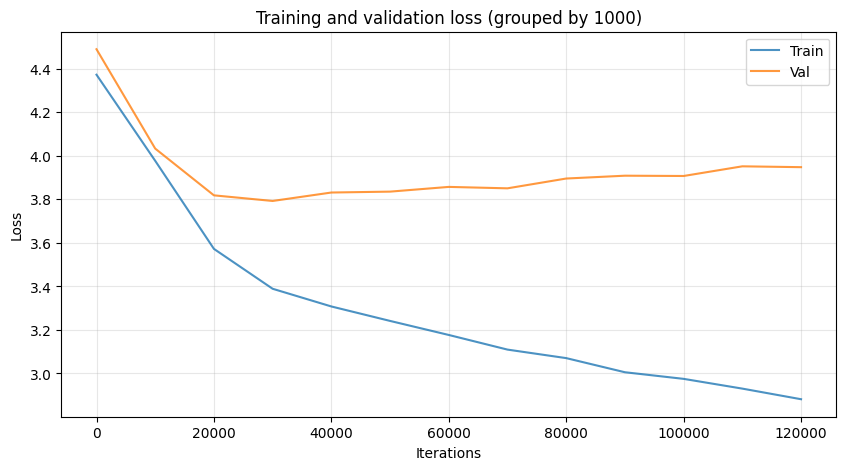

In [11]:
# Plot training and validation loss (each point = track_interval iters)
lossi = lossi_gpu[:loss_tracker_idx].cpu().tolist()
val_lossi = val_lossi_gpu[:loss_tracker_idx].cpu().tolist()
total_time = time.time() - start_time

if len(lossi) > 0:
    lossi_tensor = torch.tensor(lossi)
    val_lossi_tensor = torch.tensor(val_lossi)
    group_size = 100
    n_complete = (len(lossi_tensor) // group_size) * group_size

    lossi_grouped = lossi_tensor[:n_complete].view(-1, group_size).mean(dim=1)
    val_lossi_grouped = val_lossi_tensor[:n_complete].view(-1, group_size).mean(dim=1)
    iterations = torch.arange(lossi_grouped.numel()) * (track_interval * group_size)

    plt.figure(figsize=(10, 5))
    plt.plot(iterations, lossi_grouped.tolist(), label="Train", alpha=0.8)
    plt.plot(iterations, val_lossi_grouped.tolist(), label="Val", alpha=0.8)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and validation loss (grouped by 1000)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No loss history (training not run or no track_interval points).")

In [12]:
# Evaluation: train and val loss
@torch.no_grad()
def split_loss(split: str) -> float:
    model.eval()
    splits = {
        "train": (Xtr, Ytr, Ctr),
        "val": (Xdev, Ydev, Cdev),
        "test": (Xte, Yte, Cte),
    }
    X, Y, C = splits[split]
    n = min(2048, X.shape[0])
    Xb = X[:n].to(device)
    Yb = Y[:n].to(device)
    Cb = C[:n].to(device)
    logits, _ = model(Xb, Cb, targets=Yb)
    loss = F.cross_entropy(logits, Yb)
    return loss.item()

# print(f"Train loss: {split_loss('train'):.4f}")
print(f"Val loss:   {split_loss('val'):.4f}")

Val loss:   3.7669


In [13]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "dwarves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(
        cat_idx, tokenizer.itos, tokenizer.stoi,
        generator=gen, replace_end_with=None,
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_name}] {name}")

[dwarves] rinda crower
[dwarves] narth sithland
[dwarves] burt darnath
[dwarves] dika
[dwarves] urdle shadown
[dwarves] alastur
[dwarves] brottus
[dwarves] bra law melist
[dwarves] burnik martha
[dwarves] nil harman
[dwarves] xorothew
[dwarves] pywen lang
[dwarves] makick
[dwarves] helm mynerryn
[dwarves] darbel


In [14]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "elves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(
        cat_idx, tokenizer.itos, tokenizer.stoi,
        generator=gen, temperature=0.5, replace_end_with=" ",
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_name}] {name}")

[elves] rynd keth nanar
[elves] faline bruden dee
[elves] lynna clock roe
[elves] maeric nhalass iv
[elves] augusta lauthryn
[elves] austin lord lod
[elves] auben xorlar
[elves] warlyn lord
[elves] elsa dawn
[elves] auben normen
[elves] aelinda ryne
[elves] halfey nanther
[elves] sawin masal one
[elves] austaf nhyr lan
[elves] darrien nelm


In [16]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "humans"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(
        cat_idx, tokenizer.itos, tokenizer.stoi,
        generator=gen, temperature=0.5, replace_end_with=" ",
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_name}] {name}")

[humans] bassandra liventyr add
[humans] austra hathan los
[humans] sabra nsandra el
[humans] nym lightsong
[humans] feliana lassen
[humans] morlar nanther
[humans] mariano nurlyn
[humans] axan rhind
[humans] borin nang magre
[humans] belen rown
[humans] bassandra shadows ever
[humans] half the drum ror
[humans] baltan rund ive
[humans] brenna durs laf
[humans] wild lord rand


In [17]:
# Random category sampling
import random

gen = torch.Generator(device=device).manual_seed(2147483647 + 22)
cat_indices = list(cat_vocab.itos.keys())

for _ in range(30):
    c = random.choice(cat_indices)
    cat_label = cat_vocab.itos[c]
    name = model.generate_name(
        c, tokenizer.itos, tokenizer.stoi, generator=gen,
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_label}] {name}")

[elves] helley illance
[fang dragons] smondryndryndricis reglors
[forest gnomes] burga non
[green hags] dold winter deshni
[malaugrym] tergrathyr addlem
[hezrou] chzizzclel rorlar
[wights] virgromghlight mascurt
[avolakia] kutz qshikhtqysh
[saru] shenko rh
[amethyst dragons] veslafara nkhar
[jaculis] ambba l
[shadovar] magan keon
[gibbering mouthers] worgand mumartus eug
[deep gnomes] eustrd snolfling depcton
[lightfoot halflings] gembaldad shadowing one
[vegepygmies] pkukubachi puon
[gold dragons] flandreelcorestrakhen devorrane
[outsiders] hazera adowe
[white abishai] corci nech
[sirines] pern nuryn
[leviathans] xiel artheldarah shamna
[shifters] manue partick
[solars] haerasha mirais ren
[tanar'ri] invaroul desen antix
[hamatulas] zele rostrund
[air elementals] khazixar lanthnayr light
[shifters] grafford willstone pe
[angels] hashrun iruj
[goliaths] haran landles ii jwi
[phaerimm] queryll qellhur
